In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("employee_attrition.csv")

# Basic EDA
print(df.head())
print(df.describe())
print(df["attrition"].value_counts())

# Feature / Target split
X = df.drop("attrition", axis=1)
y = df["attrition"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Baseline model
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluation
print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]))


   age  monthly_salary  years_at_company  job_satisfaction  \
0   59    33613.042217                14          4.127564   
1   49    55475.095620                 2          4.918543   
2   35    81291.373561                18          4.563654   
3   28    62392.113378                17          7.023777   
4   41    76333.970354                 7          9.027038   

   performance_rating  work_life_balance  overtime_hours  attrition  
0            1.549447           4.412513       17.561018          0  
1            2.107480           4.734322       18.221542          1  
2            1.184252           4.730409       11.273665          0  
3            4.723296           1.500920       24.813540          1  
4            3.643194           2.528216       13.290165          1  
               age  monthly_salary  years_at_company  job_satisfaction  \
count  1200.000000     1200.000000       1200.000000       1200.000000   
mean     40.553333    59970.292013          9.603333       

In [2]:
for depth in [None, 3, 10]:
    temp_model = DecisionTreeClassifier(max_depth=depth, random_state=42)
    temp_model.fit(X_train, y_train)
    print(
        "Depth:", depth,
        "Train Accuracy:", temp_model.score(X_train, y_train),
        "Test Accuracy:", temp_model.score(X_test, y_test)
    )


Depth: None Train Accuracy: 1.0 Test Accuracy: 0.6958333333333333
Depth: 3 Train Accuracy: 0.78125 Test Accuracy: 0.7583333333333333
Depth: 10 Train Accuracy: 0.9416666666666667 Test Accuracy: 0.7208333333333333


In [3]:
param_grid = {
    "max_depth": [None, 3, 5, 10],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "criterion": ["gini", "entropy"]
}

grid = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid,
    cv=5,
    scoring="f1"
)

grid.fit(X_train, y_train)

print("Best Parameters:", grid.best_params_)
print("Best CV Score:", grid.best_score_)


Best Parameters: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best CV Score: 0.8603161291975739


In [4]:
importances = grid.best_estimator_.feature_importances_
feature_names = X.columns

importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
})

print(importance_df.sort_values(by="Importance", ascending=False))


              Feature  Importance
6      overtime_hours    0.667808
3    job_satisfaction    0.183972
1      monthly_salary    0.098407
5   work_life_balance    0.049813
0                 age    0.000000
2    years_at_company    0.000000
4  performance_rating    0.000000


In [5]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [6]:
def build_model(neurons=64, dropout_rate=0.3, learning_rate=0.001):

    model = keras.Sequential([
        layers.Dense(
            neurons,
            activation="relu",
            kernel_regularizer=regularizers.l2(0.001),
            input_shape=(X_train.shape[1],)
        ),
        layers.Dropout(dropout_rate),
        layers.Dense(neurons // 2, activation="relu"),
        layers.Dropout(dropout_rate),
        layers.Dense(1, activation="sigmoid")
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )

    return model


In [7]:
model = build_model()

history = model.fit(
    X_train_scaled,
    y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[keras.callbacks.EarlyStopping(patience=10)]
)


Epoch 1/100


c:\Users\User\Downloads\007\.conda\lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.6341 - loss: 0.6612 - val_accuracy: 0.7240 - val_loss: 0.5887
Epoch 2/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7734 - loss: 0.5636 - val_accuracy: 0.7240 - val_loss: 0.5563
Epoch 3/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7747 - loss: 0.5617 - val_accuracy: 0.7240 - val_loss: 0.5423
Epoch 4/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7721 - loss: 0.5272 - val_accuracy: 0.7240 - val_loss: 0.5305
Epoch 5/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7799 - loss: 0.5051 - val_accuracy: 0.7240 - val_loss: 0.5236
Epoch 6/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7852 - loss: 0.5017 - val_accuracy: 0.7344 - val_loss: 0.5185
Epoch 7/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7760 - loss: 0.5068 - val_accuracy: 0.7500 - val_loss: 0.5138
Epoch 8/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7734 - loss: 0.5007 - val_accuracy: 0.7500 - val_loss: 0.

In [8]:
loss, acc = model.evaluate(X_test_scaled, y_test)
print("Test Accuracy:", acc)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7833 - loss: 0.5173  
Test Accuracy: 0.7833333611488342


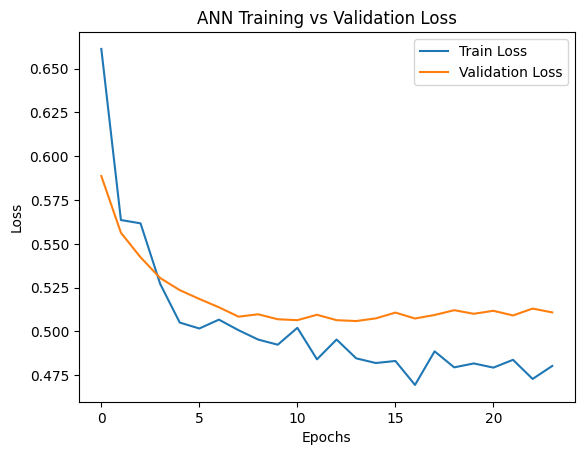

In [9]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.legend(["Train Loss", "Validation Loss"])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("ANN Training vs Validation Loss")
plt.show()
